# Soil Thresholding


In [1]:
%matplotlib inline

import sys
import os
sys.path.append("../../../..")
import inspect

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from skimage import exposure, img_as_float, morphology
from sklearn.linear_model import LinearRegression

from osgeo import gdal
from osgeo import ogr
import osr
import xml.etree.ElementTree as ET

import my_packages.My_Geoprocess as mgp


# Metadatas extraction, reading and checking

In [2]:
FilePath = '../../../Images/Acolite/S2A_OPER_MSI_L1C_TL_SGS__20160624T021134_A005246_T58KFA_N02.04/T58KFA/'
image_filePath = mgp.getNIRTifPath(FilePath)[0]
gdal.ErrorReset()
ds = gdal.Open( FilePath + image_filePath )

if ds is None or gdal.GetLastErrorMsg() != '':
    print('xml failed to load')
    
DataSet_md = ds.GetMetadata()
DataSet_md
NIR = ds.GetRasterBand(1).ReadAsArray()

In [3]:
RawImage_Folder = '../../../Images/S2A_OPER_PRD_MSIL1C_PDMC_20160624T024625_R101_V20160623T231214_20160623T231214.SAFE/'
GML_Folder = 'GRANULE/S2A_OPER_MSI_L1C_TL_SGS__20160624T021134_A005246_T58KFA_N02.04/QI_DATA/'
GML_Name = 'S2A_OPER_MSK_DETFOO_SGS__20160624T021134_A005246_T58KFA_B02_MSIL1C.gml'


# Extract Detectors FootPrints

In [4]:

DetFootGml_path =  RawImage_Folder+GML_Folder+GML_Name
InVec = ogr.Open(DetFootGml_path)
assert InVec.GetLayerCount() == 1

inLayer = InVec.GetLayer()
FieldName = [inLayer.GetLayerDefn().GetFieldDefn(i).GetName() for i in range(inLayer.GetLayerDefn().GetFieldCount())]
FeatureField = [[inLayer.GetFeature(feat).GetField(FieldName[f]) for feat in range(inLayer.GetFeatureCount())] for f in range(len(FieldName))]

<function matplotlib.pyplot.show>

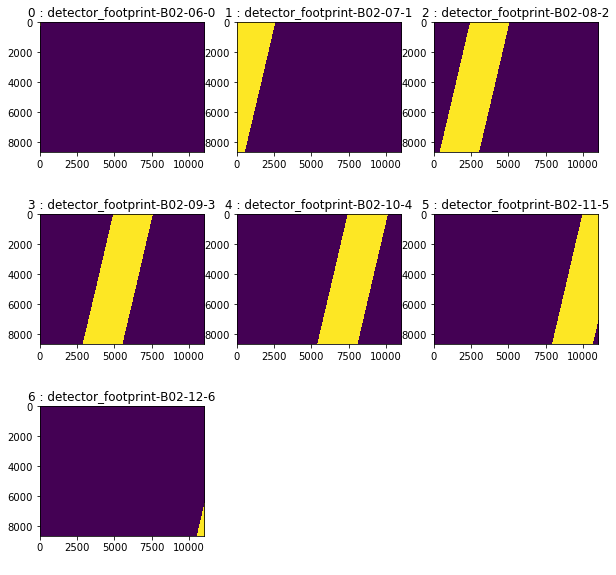

In [5]:
GT = ds.GetGeoTransform()
proj = ds.GetProjection()
cols = ds.RasterXSize
rows = ds.RasterYSize

ROI = [mgp.create_mask_from_vector(DetFootGml_path, cols, rows, GT, proj, NLayerAssert = 1, 
                              AtFilterExp = "{0}='{1}'".format(FieldName[0], FeatureField[0][f]))
       for f in range(inLayer.GetFeatureCount())]
ROI= [ROI[f].GetRasterBand(1).ReadAsArray().astype(bool) for f in range(len(ROI))]


fig, axes = plt.subplots(3,3,figsize=(10, 10))
for i, ax in enumerate(fig.axes):
    if i > 6:
        ax.axis('off')
        continue
    ax.set_title('{0} : {1}'.format(i, FeatureField[0][i]))
    ax.imshow(ROI[i])
plt.show

# detector's Footprint definition  !!! To be mdified for each GN Application !!!

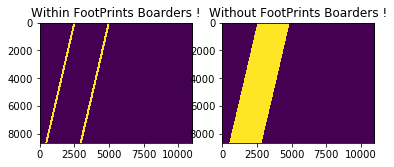

In [7]:
fig, axes = plt.subplots(1,2)
FP = 2
axes[0].set_title('Within FootPrints Boarders !')
axes[0].imshow(np.logical_and(ROI[FP], np.logical_or(ROI[FP-1],ROI[FP+1])))
axes[1].set_title('Without FootPrints Boarders !')
axes[1].imshow(np.logical_and(ROI[FP], ~np.logical_or(ROI[FP-1],ROI[FP+1])))

In [8]:
TempoFolder = '/vsimem/'
ShapeFolder = '../../ShapesAndMask/'
MaskName = 'ROI.tif'
ShapeName = 'ROI.shp'

ROI = np.logical_and(ROI[FP], ~np.logical_or(ROI[FP-1],ROI[FP+1]))
ROIrecord = np.full(ROI.shape, np.nan, np.float)

mgp.write_raster2(TempoFolder+MaskName,ROI, GT, proj, DriverName="GTiff", formatMem=gdal.GDT_Byte)
ROISource = gdal.Open(TempoFolder+MaskName)
ROIBand = ROISource.GetRasterBand(1)

drv = ogr.GetDriverByName("ESRI Shapefile")
dst_ds = drv.CreateDataSource(ShapeFolder+ShapeName)
Srs = osr.SpatialReference()
Srs.ImportFromWkt(ROISource.GetProjectionRef())
dst_layer = dst_ds.CreateLayer(ShapeFolder+ShapeName, srs=Srs)
newField = ogr.FieldDefn('Class', ogr.OFTInteger)
dst_layer.CreateField(newField)
gdal.Polygonize(ROIBand, ROIBand,dst_layer, 0,[],callback=None)  
dst_ds.Destroy()

<function matplotlib.pyplot.show>

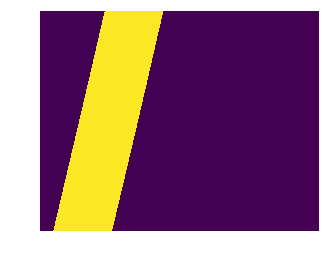

In [9]:
Roi_Path = ShapeFolder+ShapeName

GT = ds.GetGeoTransform()
proj = ds.GetProjection()
cols = ds.RasterXSize
rows = ds.RasterYSize

ROI = mgp.create_mask_from_vector(Roi_Path, cols, rows, GT, 
                              proj, target_value=1, format=gdal.GDT_Byte)
ROI= ROI.GetRasterBand(1).ReadAsArray().astype(bool)

plt.figure(figsize=(5, 5))
#plt.subplot(1, 2, 1)
plt.imshow(ROI)
#plt.subplot(1, 2, 2)
#plt.imshow(Random)
plt.axis('off')
plt.show
